In [1]:
#mount google drive when on google colab and set working directory

import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/music_speech/')

working_dir = os.getcwd()
print(f'\nWorking directory: {working_dir}')


Working directory: /Users/kraehenb/music_speech


In [2]:
#check working directory and repo (git clone git@github.com:jkcas22/music_speech.git)

!{sys.executable} -m pip install gitpython
import git

repo = ['git@github.com:jkcas22/music_speech.git', 'https://github.com/jkcas22/music_speech.git']

if git.Repo(working_dir).remotes.origin.url in repo:
    print(f'\nRepository and working directory are fine.')
else:
    print(f'\nRepository: {git.Repo(working_dir).remotes.origin.url}')


Repository and working directory are fine.


In [3]:
#initialize environment, load modules/libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#import python code from seperate files
from helpers.fourier_transform import load_wav, dft_logmag, patches

2023-02-05 13:43:11.349922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
music_dir = './data/music_wav'
if not os.path.isdir(music_dir): 
    print(f'copy folder "music_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

music_test = [
    'unpoco.wav',
    'blues.wav',
    'gismonti.wav',
    'ipanema.wav',
    'deedee.wav',
    'hendrix.wav',
    'madradeus.wav',
    'marlene.wav',
    'beatles.wav',
    'bagpipe.wav',
    'redhot.wav',
    'jazz.wav'
]
music_test = [os.path.join(music_dir, file) for file in music_test]

music = [os.path.join(music_dir, file) for file in os.listdir(music_dir) if file.endswith('.wav')]
music = list(set(music)-set(music_test))

speech_dir = './data/speech_wav'
if not os.path.isdir(speech_dir): 
    print(f'copy folder "speech_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

speech_test = [
    'comedy.wav',
    'thlui.wav',
    'voices.wav',
    'conversion.wav',
    'china.wav',
    'vegetables2.wav',
    'amal.wav',
    'teachers2.wav',
    'chant.wav',
    'pulp2.wav',
    'acomic.wav',
    'kid.wav'
]
speech_test = [os.path.join(speech_dir, file) for file in speech_test]

speech = [os.path.join(speech_dir, file) for file in os.listdir(speech_dir) if file.endswith('.wav')]
speech = list(set(speech)-set(speech_test))
	  
print (len(music), len(speech))

52 52


In [5]:
mus = load_wav(music_test)
mus.shape

(12, 661500)

In [7]:
fft_step=256
fft_size=512
fft_chunks = len(mus[0])//fft_step

logmag = dft_logmag(mus,fft_chunks,fft_step,fft_size)
print(logmag.shape)

patch_step = 32
patch_size = 64
logmag_patches = patches(logmag,patch_step,patch_size)
print(logmag_patches.shape)

(12, 2583, 256)
(12, 79, 64, 256)


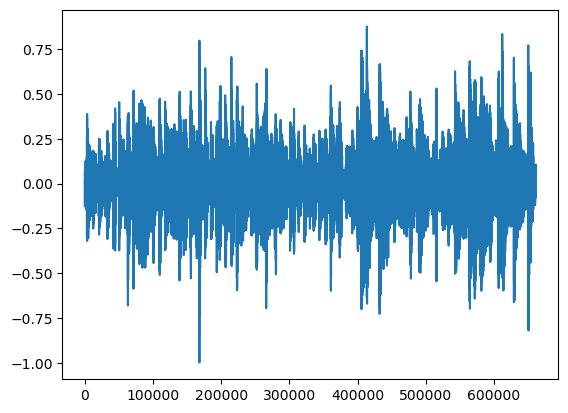

In [8]:
plt.plot(mus[3])
plt.show()

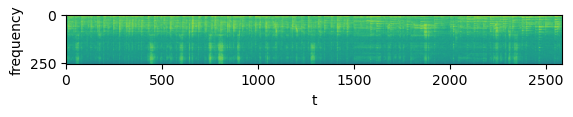

In [9]:
plt.imshow(logmag[3].T)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()

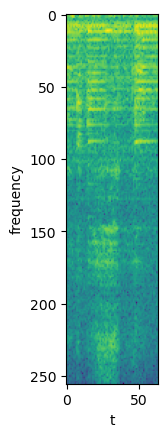

In [11]:
plt.imshow(logmag_patches[3,0].T)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()

In [ ]:
# np.savez_compressed('./data/music_test.npz', music=mus)
# np.savez_compressed('./data/music_test_freq.npz', logmag=logmag)